#########################################################################
MoRed - GeM Laboratory
ECOLE CENTRALE DE NANTES
#########################################################################

In [ ]:
import os
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.tri import Triangulation

In [ ]:
from library import FEM_mat_2D, eim

 LOAD FULL ORDER SOLUTION

In [ ]:
X = np.loadtxt('FEM_Solution/X.txt', delimiter=',')
Y = np.loadtxt('FEM_Solution/Y.txt', delimiter=',')
time = np.loadtxt('FEM_Solution/time.txt', delimiter=',')
connectAll = np.loadtxt('FEM_Solution/connectAll.txt', delimiter=',', dtype=int)
solution = np.loadtxt('FEM_Solution/solution.txt', delimiter=',')
maskDir = np.loadtxt('FEM_Solution/maskDir.txt', delimiter=',', dtype=bool)
density = np.loadtxt('FEM_Solution/density.txt', delimiter=',')
k0 = np.loadtxt('FEM_Solution/k0.txt', delimiter=',')
specificHeat = np.loadtxt('FEM_Solution/specificHeat.txt', delimiter=',')
nodesAll = np.column_stack((X, Y))
condfun = lambda T: k0*(1+0.5*((T+1)**5-1))

 SET MASK CORRESPONDING TO TRAINING TIME

In [ ]:
timeSpanTrain = 0.2
timeSpan = time.max()
maskTrain = (time<timeSpanTrain)
timeTrain = time[maskTrain]
print(f'Snapshots up to time={timeTrain.max():0.3e}s being used for training')

Snapshots up to time=1.900e-01s being used for training


 SUBSPACE TRUNCATION THRESHOLD

In [ ]:
threshold = 1e-4

 EVALUATE NON-LINEAR TERM (CONDUCTIVITY)

In [ ]:
condfield = condfun(solution[:,maskTrain])
solution = solution[np.ix_(maskDir,maskTrain)]

### REDUCED BASIS FOR SOLUTION

 SINGULAR VALUE DECOMPOSITION

In [ ]:
[leftSingularVectors, singularValues, _] = np.linalg.svd(solution, full_matrices=False)
maskTruncation = np.zeros(leftSingularVectors.shape[1], dtype=bool)

 SUBSPACE TRUNCATION<br>
singularValues = np.diag(singularValues)

In [ ]:
weights = 1 - singularValues.cumsum()/singularValues.sum()
maskTruncation[weights>=threshold] = True

 REDUCED BASIS. ONLY EIGVECTORS FROM EIGENVALUES GREATER THAN THRESHOLD

In [ ]:
reducedBasis = np.zeros([maskDir.size, sum(maskTruncation)])
reducedBasis[maskDir,:] = leftSingularVectors[:,maskTruncation]

### REDUCED BASIS FOR NONLINEAR TERM

 SINGULAR VALUE DECOMPOSITION

In [ ]:
[leftSingularVectors,singularValues,_] = np.linalg.svd(condfield, full_matrices=False)     # to complete
maskTruncation = np.zeros(leftSingularVectors.shape[1], dtype=bool)# to complete

 SUBSPACE TRUNCATION<br>

In [ ]:
weights_c = 1 - singularValues.cumsum()/singularValues.sum()# to complete
maskTruncation[weights_c>=threshold] = True

 REDUCED BASIS. ONLY EIGVECTORS FROM EIGENVALUES GREATER THAN THRESHOLD

In [ ]:
reducedBasis_c = leftSingularVectors[:,maskTruncation]

### Assemble reduced Mass Matrix

 
 Hi-Fi Operator

In [ ]:
M = FEM_mat_2D(nodesAll,connectAll,0,0,0,0)
## Galerkin Projection
M_r = reducedBasis.T @ M @ reducedBasis           # to complete

 Assemble reduced Diffusion Operator Matrix (affine decomposition)

In [ ]:
K_r = [None for i in range(reducedBasis_c.shape[1])]
for i in range(reducedBasis_c.shape[1]):
    Kx = FEM_mat_2D(nodesAll,connectAll,1,0,1,0,lin_fields=np.atleast_2d(reducedBasis_c[:,i]).T)
    Ky = FEM_mat_2D(nodesAll,connectAll,0,1,0,1,lin_fields=np.atleast_2d(reducedBasis_c[:,i]).T)
    opConduc = Kx+Ky
    K_r[i] = reducedBasis.T @ opConduc @ reducedBasis       # to complete

### EIM

EIM POINTS

In [ ]:
intPoints = eim(reducedBasis_c)

 Interpolation Matrices

In [ ]:
Int_t =  reducedBasis[intPoints,:]   # to complete # temperature
Int_c = reducedBasis_c[intPoints, :] # to complete # conductivity

### SAVE REDUCED QUANTITIES

In [ ]:
os.makedirs('Reduced_Basis/plots', exist_ok=True)
np.savetxt('Reduced_Basis/reducedBasis.txt', reducedBasis, delimiter=',')
np.savetxt('Reduced_Basis/reducedBasis_c.txt', reducedBasis_c, delimiter=',')
np.savetxt('Reduced_Basis/M_r.txt', M_r, delimiter=',')
for i in range(len(K_r)):
    np.savetxt(f'Reduced_Basis/K_r_{i}.txt', K_r[i], delimiter=',')
np.savetxt('Reduced_Basis/Int_t.txt', Int_t, delimiter=',')
np.savetxt('Reduced_Basis/Int_c.txt', Int_c, delimiter=',')
np.savetxt('Reduced_Basis/density.txt', [density], delimiter=',')
np.savetxt('Reduced_Basis/k0.txt', [k0], delimiter=',')
np.savetxt('Reduced_Basis/specificHeat.txt', [specificHeat], delimiter=',')

### PLOT RESULTS

PLOT WEIGHTS OF SOLUTION BASIS

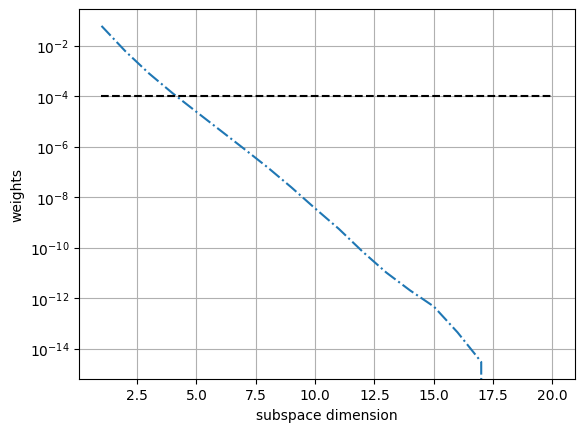

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(np.arange(1, weights.size+1), weights, linestyle='dashdot')
ax.semilogy(np.arange(1, weights.size+1), threshold*np.ones(weights.size), linestyle='dashed', color='k')
ax.grid()
ax.set_xlabel('subspace dimension')
ax.set_ylabel('weights')
fig.savefig(f'Reduced_Basis/plots/weights.png')

 PLOT BASIS FUNCTIONS (Dynamic plots may not work on notebooks/deepnote. In that case, visualize the solution using the saved (png) figures)

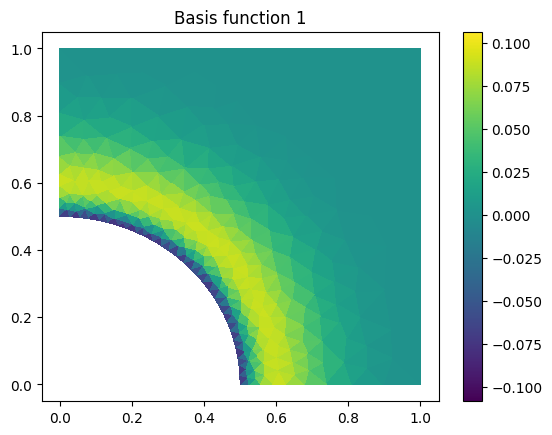

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
function2plot = reducedBasis[:,0]
vmin = 0.9*reducedBasis.min()
vmax = 1.1*reducedBasis.max()

if connectAll.shape[1]==4:
    f1 = ax.pcolormesh([X, Y], function2plot, vmin=vmin, vmax=vmax)
    ax.set_title(f'Basis function {0}')
    fig.colorbar(f1, ax=ax)
    for i in range(1, reducedBasis.shape[1]):
        function2plot = reducedBasis[:,i]
        f1.set_array(function2plot)
        ax.set_title(f'Basis function {i}')
        fig.savefig(f'Reduced_Basis/plots/RBu_{i}.png')
        plt.pause(5/reducedBasis.shape[1])
elif connectAll.shape[1]==3:
    Tri = Triangulation(X, Y, triangles=connectAll)
    f1 = ax.tripcolor(Tri, function2plot, vmin=vmin, vmax=vmax)
    ax.set_title(f'Basis function {0}')
    fig.colorbar(f1, ax=ax)
    for i in range(1, reducedBasis.shape[1]):
        function2plot = reducedBasis[:,i]
        f1 = ax.tripcolor(Tri, function2plot, vmin=vmin, vmax=vmax)
        ax.set_title(f'Basis function {i}')
        fig.savefig(f'Reduced_Basis/plots/RBu_{i}.png')
        plt.pause(5/reducedBasis.shape[1])

PLOT WEIGHTS OF NON-LINEAR TERM BASIS

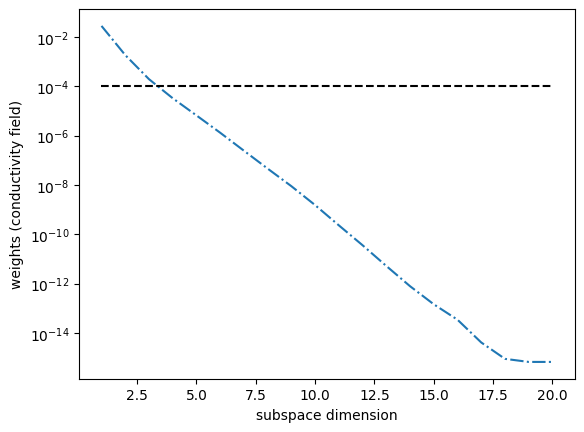

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.semilogy(np.arange(1, weights_c.size+1), weights_c, linestyle='dashdot')
ax.semilogy(np.arange(1, weights_c.size+1), threshold*np.ones(weights_c.size), linestyle='dashed', color='k')
ax.set_xlabel('subspace dimension')
ax.set_ylabel('weights (conductivity field)')
fig.savefig(f'Reduced_Basis/plots/weights_k.png')

 PLOT BASIS FUNCTIONS (Dynamic plots may not work on notebooks/deepnote. In that case, visualize the solution using the saved (png) figures)

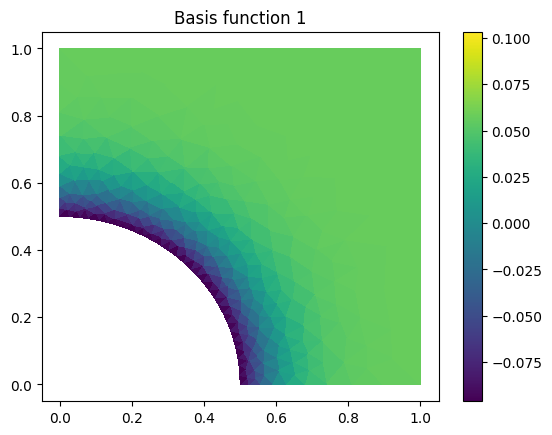

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
function2plot = reducedBasis_c[:,0]
vmin = 0.9*reducedBasis_c.min()
vmax = 1.1*reducedBasis_c.max()

if connectAll.shape[1]==4:
    f1 = ax.pcolormesh([X, Y], function2plot, vmin=vmin, vmax=vmax)
    ax.set_title(f'Basis function {0}')
    fig.colorbar(f1, ax=ax)
    for i in range(1, reducedBasis_c.shape[1]):
        function2plot = reducedBasis_c[:,i]
        f1.set_array(function2plot)
        ax.set_title(f'Basis function {i}')
        fig.savefig(f'Reduced_Basis/plots/RBk_{i}.png')
        plt.pause(5/reducedBasis_c.shape[1])
elif connectAll.shape[1]==3:
    f1 = ax.tripcolor(Tri, function2plot, vmin=vmin, vmax=vmax)
    ax.set_title(f'Basis function {0}')
    fig.colorbar(f1, ax=ax)
    for i in range(1, reducedBasis_c.shape[1]):
        function2plot = reducedBasis_c[:,i]
        f1 = ax.tripcolor(Tri, function2plot, vmin=vmin, vmax=vmax)
        ax.set_title(f'Basis function {i}')
        fig.savefig(f'Reduced_Basis/plots/RBk_{i}.png')
        plt.pause(5/reducedBasis_c.shape[1])

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=6e4ec535-1a42-4f7f-9f57-76554989f508' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>